## Segmentor Training
In this notebook i trained a segmentation-model, to find mask of a meter for calculating readings

In [ ]:
!pip install -U segmentation-models  # for model artitecture
!pip install -U albumentations       # for image augmentation

In [ ]:
import segmentation_models as sm
import albumentations as A

import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib

sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
seg = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_seg.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [seg]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

## Image augmentation

I didn't went wild on data expansion i just tripled
 the instances with Albumentation library ie. just 374 to 1122

In [ ]:
augmentor = A.Compose([A.HorizontalFlip(p=0.5), 
                       A.ShiftScaleRotate(p=0.5),  # rotates image
                       A.Blur(blur_limit=3),       # blur image
                       A.ColorJitter(),            # augment Brightness , contrast , saturation
                       A.RGBShift()])              # RGB shifts

In [ ]:
augmented_data = pathlib.Path('augmented_data')
augmented_image = pathlib.Path('augmented_data/augmented_images')
augmented_label = pathlib.Path('augmented_data/augmented_labels')

augmented_data.mkdir(exist_ok=True)
augmented_image.mkdir(exist_ok=True)
augmented_label.mkdir(exist_ok=True)

In [ ]:
for i in sorted(os.listdir('/content/meter_seg/images/train')):
    img_path = '/content/meter_seg/images/train/' + i
    ann_path = '/content/meter_seg/annotations/train/' + i[:-3] +'png'

    for t in range(3):
        img = cv2.imread(img_path)
        ann = cv2.imread(ann_path)

        augmented = augmentor(image=img,mask=ann)
        augmented_img = augmented['image']
        augmented_ann = augmented['mask']

        cv2.imwrite(str(augmented_image)+ '/' + i[:-4] + str(t) + '.jpg', augmented_img)
        cv2.imwrite(str(augmented_label)+ '/' + i[:-4] + str(t) + '.png', augmented_ann)


## Training
First i loaded the augmented data, then initialized the model with SegmentationModel library which have some pre-defined segmentation-DL artitechtures in TensorFlow's Keras

In [ ]:
def load_image(path,mask=False):
    images = []
    for i in sorted(os.listdir(path)):
        img = cv2.imread(path+'/'+i,0 if mask else 1)
        if not mask : img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img,(256,256),cv2.INTER_AREA)
        images.append(img)
    return np.array(images)

In [ ]:
train_image = load_image('/content/augmented_data/augmented_images')
train_ann = load_image('/content/augmented_data/augmented_labels',mask=True)
train_ann = tf.keras.utils.to_categorical(train_ann)

In [ ]:
train_image.shape

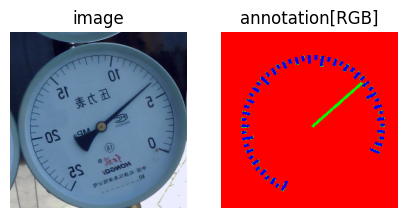

In [ ]:
rand_idx = np.random.randint(0,len(train_image))
plt.figure(figsize=(5,7))
plt.subplot(121);plt.imshow(train_image[rand_idx]);plt.axis(False);plt.title('image')
plt.subplot(122);plt.imshow(train_ann[rand_idx]);plt.axis(False);plt.title('annotation[RGB]')
plt.show()

In [ ]:
model = sm.Unet('resnet50',classes=3,activation='softmax')

In [ ]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metric = [tf.keras.metrics.MeanIoU(3)]
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.compile(opt,loss,metric)

his = model.fit(train_image,train_ann,batch_size=20,epochs=20,validation_split=0.2,callbacks=[callback])

In [ ]:
model.save('train_model.h5')

In [ ]:
val_image = load_image('/content/meter_seg/images/val')
val_ann = load_image('/content/meter_seg/annotations/val',mask=True)

In [ ]:
val_pred = model.predict(val_image,verbose=0.1)
val_pred = np.argmax(val_pred,axis=3)

In [ ]:
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0, hspace=0) 

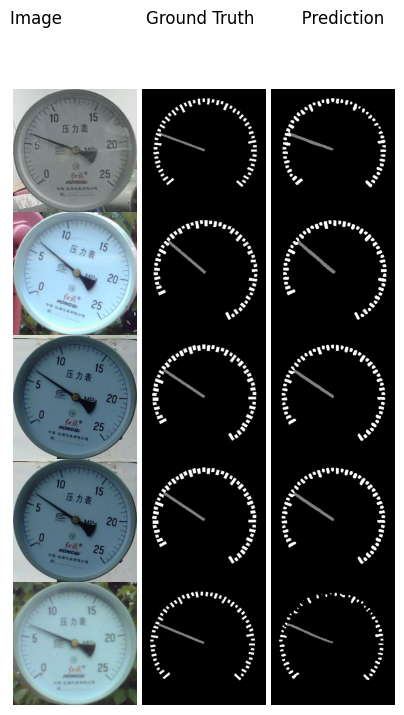

In [ ]:
plt.figure(figsize=(5,8))
for i in range(5):
    rand_idx = np.random.randint(0,len(val_image))
    plt.subplot(5,3,1+(i*3));plt.imshow(val_image[rand_idx]);plt.axis(False);
    plt.subplot(5,3,2+(i*3));plt.imshow(val_ann[rand_idx],cmap='gray');plt.axis(False);
    plt.subplot(5,3,3+(i*3));plt.imshow(val_pred[rand_idx],cmap='gray');plt.axis(False);

plt.suptitle('Image                Ground Truth         Prediction')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()